<a href="https://colab.research.google.com/github/hoangp/isbi-datasets/blob/upload_colab/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install / Import dependencies

In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

Using TensorFlow backend.


### Load datasets


In [0]:
# mounth gdrive
from google.colab import drive
drive.mount('/content/gdrive')

project_path = 'gdrive/My Drive/cs9517-19t2-project'

In [0]:
#!rm -rf gdrive/My\ Drive/cs9517-19t2-project/output

!mkdir -p gdrive/My\ Drive/cs9517-19t2-project
!mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output
!mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/aug
!mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/unet
!mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/unet/models
!mkdir -p gdrive/My\ Drive/cs9517-19t2-project/output/unet/results

### Parameters

In [0]:
data_train_path = project_path + '/data/images'
data_label_path = project_path + '/data/labels'
data_img_type = 'jpg'

output_path     = project_path + '/output'  
aug_path        = project_path + '/output/aug' 

image_size = 512
target_size = 128 # smaller target_size for quicker training

num_aug_batches = 32 # total augmented images = num_imgs * num_aug_batches

### Load and pre-process original data

In [24]:
# get data images and labels filenames
train_filenames = glob.glob(data_train_path + "/*." + data_img_type)
label_filenames = glob.glob(data_label_path + "/*." + data_img_type)

train_filenames.sort()
label_filenames.sort()

num_imgs = len(train_filenames)

# TRAIN ALL DATA
X_org = np.ndarray((num_imgs, target_size, target_size, 1), dtype=np.float32)
y_org = np.ndarray((num_imgs, target_size, target_size, 1), dtype=np.float32)

for i in range(num_imgs):
    arr_t = img_to_array(load_img(train_filenames[i], color_mode = "grayscale"))
    arr_l = img_to_array(load_img(label_filenames[i], color_mode = "grayscale"))
    
    if i % 10 == 0:
        print('loading', train_filenames[i].split('/')[-1], 'and', 
                         label_filenames[i].split('/')[-1], '...')
    
    # resize for faster training
    if target_size < image_size:
        arr_t = resize(arr_t, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)
        arr_l = resize(arr_l, (target_size, target_size, 1), 
                       mode = 'constant', preserve_range = True)
        
    X_org[i] = arr_t
    y_org[i] = arr_l
    
# CODE SNIPPETS: Split data into train and test set
# from sklearn.model_selection import train_test_split
# X_org, X_test, y_org, y_test = train_test_split(X_org, y_org, test_size=0.1)

# TEST ALL DATA
X_test = X_org / 255.0
y_test = y_org / 255.0

print('X_org : shape =', X_org.shape, ', min =', np.min(X_org), ', max =', np.max(X_org))
print('y_org : shape =', y_org.shape, ', min =', np.min(y_org), ', max =', np.max(y_org))
print('X_test: shape =', X_test.shape, ', min =', np.min(X_test), ', max =', np.max(X_test))
print('y_test: shape =', y_test.shape, ', min =', np.min(y_test), ', max =', np.max(y_test))

loading train-volume00.jpg and train-labels00.jpg ...
loading train-volume10.jpg and train-labels10.jpg ...
loading train-volume20.jpg and train-labels20.jpg ...
X_org : shape = (30, 128, 128, 1) , min = 1.0254124 , max = 252.1164
y_org : shape = (30, 128, 128, 1) , min = 0.0 , max = 255.0
X_test: shape = (30, 128, 128, 1) , min = 0.004021225 , max = 0.98869175
y_test: shape = (30, 128, 128, 1) , min = 0.0 , max = 1.0


### Visualize a random original data

Original train / label image 18


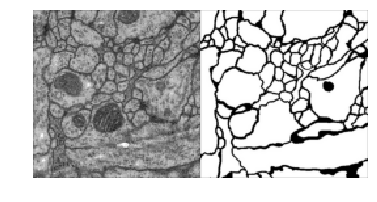

In [18]:
i = random.randint(0, len(X_org) - 1)

img_t = array_to_img(X_org[i])
img_l = array_to_img(y_org[i])

plt.imshow(np.hstack((img_t, img_l)), cmap='gray')
plt.axis('off')
print('Original train / label image', i)

### Generate augmented images

In [25]:
# delete current augmentation data
!rm gdrive/My\ Drive/cs9517-19t2-project/output/aug/*

# Generate batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
#
# ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
#     featurewise_std_normalization=False, samplewise_std_normalization=False, 
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, 
#     width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, 
#     shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', 
#     cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, 
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)
#
# (https://keras.io/preprocessing/image/)

datagen = ImageDataGenerator(rotation_range=10, shear_range=0.1,  zoom_range=0.1,
     horizontal_flip=True, vertical_flip=True, fill_mode='constant', cval=0)

# merge label and train, one by one augmentation
for i in range(num_imgs):
    arr_t = X_org[i]
    arr_l = y_org[i]

    s = np.shape(arr_t) # either image_size or target_size
    
    # Create data & label arrays for ImageDataGenerator.flow()
    arr_tl = np.ndarray(shape=(s[0],s[1],3), dtype=np.uint8) # (size, size, 3)
    arr_tl[:,:,0] = arr_t[:,:,0]
    arr_tl[:,:,2] = arr_l[:,:,0]
    arr_tl = arr_tl.reshape((1,) + arr_tl.shape) # (1, size, size, 3) -> Rank 4

    if i % 10 == 0:
        print("Generate augmented data for data & label array " + str(i) + " ...")

    # Takes data & label arrays, generates batches of augmented data.
    # flow(x, y=None, batch_size=32, shuffle=True, sample_weight=None, seed=None, 
    #      save_to_dir=None, save_prefix='', save_format='png', subset=None)
    batches = 0
    for batch in datagen.flow(arr_tl, batch_size=1, save_to_dir=aug_path):
        batches += 1
        if batches >= num_aug_batches:
            break
            # we need to break the loop by hand because
            # the generator loops indefinitely       

aug_filenames = glob.glob(aug_path + "/*.*")

print("No. of augmented images =", len(aug_filenames), "(saved to " + aug_path + ")")

Generate augmented data for data & label array 0 ...
Generate augmented data for data & label array 10 ...
Generate augmented data for data & label array 20 ...
No. of augmented images = 922 (saved to gdrive/My Drive/cs9517-19t2-project/output/aug)


### Visuazlize a random augmented image

Augmented (train / label) image 362


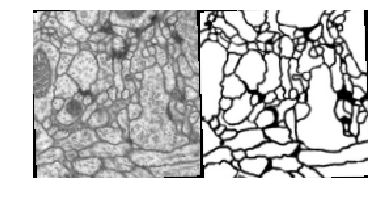

In [44]:
i = random.randint(0, len(aug_filenames) - 1)

arr = img_to_array(load_img(aug_filenames[i]))

img_t = array_to_img(arr[:,:,:1]*255)
img_l = array_to_img(arr[:,:,2:])

plt.imshow(np.hstack((img_t, img_l)), cmap='gray')
plt.axis('off')
print('Augmented (train / label) image', i)

### Create train data from augmented images

In [22]:
X_train = np.ndarray((len(aug_filenames), target_size, target_size, 1), dtype=np.float32)
y_train = np.ndarray((len(aug_filenames), target_size, target_size, 1), dtype=np.float32)

# Load images from augmentation folder
for i in range(len(aug_filenames)):
    if i % 100 == 0:
        print("loading training data " + str(i) + " ...")
    
    arr = img_to_array(load_img(aug_filenames[i]))
    X_train[i] = arr[:,:,:1] / 255.0
    y_train[i] = arr[:,:,2:] / 255.0

    # convert y_train to 0 and 1
    y_train[y_train > 0.5] = 1
    y_train[y_train <= 0.5] = 0

# OPTIONAL: save train data to disk
# print('Saving train dara to disk...')
# np.save(output_path + '/X_train.npy', X_train)
# np.save(output_path + '/y_train.npy', y_train)

print('X_train: shape =', X_train.shape, ', min =', np.min(X_train), ', max =', np.max(X_train))
print('y_train: shape =', y_train.shape, ', min =', np.min(y_train), ', max =', np.max(y_train))

loading training data 0 ...
loading training data 100 ...
loading training data 200 ...
loading training data 300 ...
loading training data 400 ...
loading training data 500 ...
loading training data 600 ...
loading training data 700 ...
loading training data 800 ...
loading training data 900 ...
X_train: shape = (916, 128, 128, 1) , min = 0.0 , max = 0.9843137
y_train: shape = (916, 128, 128, 1) , min = 0.0 , max = 1.0


### Visuazlize a random train data

X_train | y_train | augmented label 769


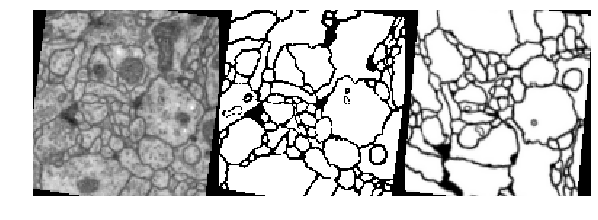

In [45]:
i = random.randint(0, len(X_train) - 1)

img_t = array_to_img(X_train[i])
img_l = array_to_img(y_train[i])

arr = img_to_array(load_img(aug_filenames[i]))
img_l2 = array_to_img(arr[:,:,2:])

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack((img_t, img_l, img_l2)), cmap='gray')
plt.axis('off')
print('X_train | y_train | augmented label', i)

## CNN models

### UNet

In [0]:
from keras.layers import *

class UNet:
    def __init__(self, target_size = None):
        self.target_size = target_size
        self.model = None
        if target_size:
            self.model = self._get_unet()
        
        self.batch_size = None
        self.model_save_path = output_path + '/unet/models'
        self.result_save_path = output_path + '/unet/results'

    def _get_unet(self):
        from keras.models import Model
        from keras.optimizers import Adam
        inputs = Input((self.target_size, self.target_size,1))
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)
        up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = concatenate([drop4,up6],axis = 3)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = concatenate([conv3,up7],axis = 3)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
        up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = concatenate([conv2,up8],axis = 3)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
        up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 =concatenate([conv1,up9],axis = 3)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
        model = Model(inputs = inputs, outputs = conv10)
        model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
        return model
    
    def disp_summary(self):
        seld.model.summary()
        
    def train(self, X_train, y_train, batch_size, epochs):
        # Trains the model for a given number of epochs (iterations on a dataset).
        # fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, 
        #     validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, 
        #     sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
        # batch_size: Number of samples per gradient update. If unspecified, batch_size will default to 32.
        # verbose: Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        # (https://keras.io/models/model/)    
        save_name = 'unet' + '.shape-' + str(target_size) + \
                                        '.train-' + str(len(X_train)) + \
                                        '.batch-' + str(batch_size) + \
                                        '.epoch-' + str(epochs)
        from keras.callbacks import ModelCheckpoint
        model_checkpoint = ModelCheckpoint(self.model_save_path + '/' + save_name + '.hdf5', 
                                           monitor='loss', verbose=1, save_best_only=True)       
        self.model.fit(X_train, y_train, batch_size, epochs, 
                       validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])
        
    def predict(self, X_test):
        return self.model.predict(X_test, batch_size=self.batch_size, verbose=1)
    
    def predict_and_save(self, X_test):
        y_pred = self.predict(X_test)
        
        print('Saving ' + str(len(y_pred)) + ' images to ' + self.result_save_path)   
        
        for i in range(y_pred.shape[0]):
            img = array_to_img(y_pred[i])
            img.save(self.result_save_path + "/" + str(i)+".png")
            
        return y_pred
        
    def load(self, filepath):         
        # extract model info from filename
        s_path   = filepath.split('/')
        s_name   = s_path[-1].split('.')  # ['unet', 'shape-128', 'train-700', 'batch-4', 'epoch-5', 'hdf5']
        s_target = s_name[1].split('-')   # ['shape', '128']
        s_batch  = s_name[3].split('-')   # ['batch', '4']
        self.target_size = int(s_target[1])
        self.batch_size  = int(s_batch[1])
        
        print('loading model ' +  s_path[-1] + ' ...')     
        
        from keras.models import load_model
        self.model = load_model(filepath)   

### Select a model

In [0]:
model = UNet(target_size)

### Train

In [49]:
model.train(X_train, y_train, batch_size=32, epochs=1)

Train on 732 samples, validate on 184 samples
Epoch 1/1
732/732 [==============================] - 849s 1s/step - loss: 0.5729 - acc: 0.7152 - val_loss: 0.5014 - val_acc: 0.7483

Epoch 00001: loss improved from inf to 0.57286, saving model to gdrive/My Drive/cs9517-19t2-project/output/unet/models/unet.shape-128.train-916.batch-32.epoch-1.hdf5


### Predict

In [56]:
y_pred = model.predict_and_save(X_test)

30/30 [==============================] - 8s 263ms/step
Saving 30 images to gdrive/My Drive/cs9517-19t2-project/output/unet/results


### Visualize a random predictions

Comparision: original / prediction / ground-truth 22


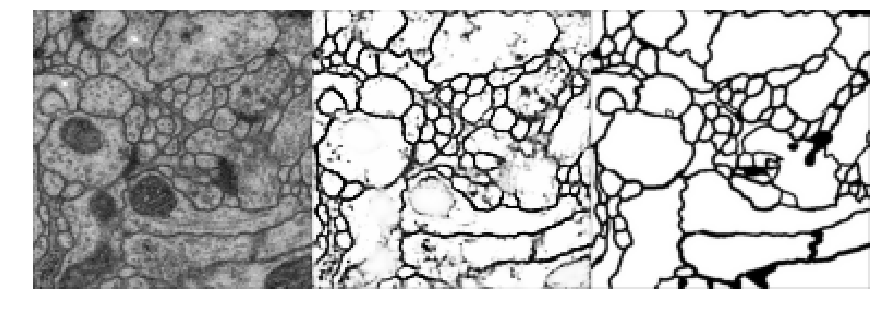

In [57]:
i = random.randint(0, len(X_test) - 1)

img_t = array_to_img(X_test[i])
img_p = array_to_img(y_pred[i])
img_l = array_to_img(y_test[i])

plt.figure(figsize=(15, 15))
plt.imshow(np.hstack((img_t, img_p, img_l)), cmap='gray')
plt.axis('off')
print('Comparision: original / prediction / ground-truth', i)

## Code Snippets

### Load model from file

In [55]:
model = UNet()
model.load(output_path + '/unet/models/unet.shape-128.train-900.batch-4.epoch-5.hdf5')

loading model unet.shape-128.train-900.batch-4.epoch-5.hdf5 ...
